# Содержание
- Содержание
- Постановка задачи
- Выгрузка данных
- Анализ данных
- Подготовка данных
- Построение нейронной сети
- Улучшение сети
- Выводы

# Постановка задачи

На основе данных характеристик 240 звезд нужно построить нейронную сеть, которая будет предсказывать температуру на поверхности новых звезд.
<br/><br/>
Количественные показатели:
- Относительная светимость (L/Lo) - относительно Солнца
- Относительный радиус (R/Ro) - относительно Солнца
- Абсолютная звездная величина (Mv) - физическая величина
<br/><br/>

Качественные показатели:
- Звездный цвет - ('white', 'red', 'blue', 'yellow', 'yellow-orange', etc)
- Тип звезды - (0, 1, 2, 3, 4, 5)
  - 0 - Коричневый карлик
  - 1 - Красный карлик
  - 2 - Белый карлик
  - 3 - Звезды главной последовательности
  - 4 - Сверхгигант
  - 5 - Гипергигант
<br/><br/>

Количественный результат:
- Абсолютная температура (T(K)) - температура на поверхности звезды в Кельвинах
<br/><br/>

Предварительный анализ:
- Результат количественный - на выходе можно ожидать алгоритм регрессии
- Функция потерь - MSE / MAE
- С количеством скрытых слоев придется экспериментировать
  - Много показателей (измерений), скорее всего 3-5 скрытых слоев будет лучше работать

# Выгрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
import random
import time
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [3]:
LOCAL_PATH = './datasets/6_class.csv'
WEB_PATH = '/datasets/6_class.csv'

RANDOM_STATE = 2023

In [4]:
if os.path.exists(LOCAL_PATH):
    df = pd.read_csv(LOCAL_PATH, index_col=0)
elif os.path.exists(WEB_PATH):
    df = pd.read_csv(WEB_PATH, index_col=0)

# Анализ данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


в данных нет пропусков

### Пореименнуем колонки, чтобы было легче их использовать

In [6]:
df = df.rename(columns={
    'Temperature (K)': 'temp',
    'Luminosity(L/Lo)': 'lumin',
    'Radius(R/Ro)': 'radius',
    'Absolute magnitude(Mv)': 'magnitude',
    'Star type': 'type',
    'Star color': 'color'
})

In [7]:
df.columns

Index(['temp', 'lumin', 'radius', 'magnitude', 'type', 'color'], dtype='object')

### Проверим категориальные данные

In [8]:
pd.value_counts(df.type)

0    40
1    40
2    40
3    40
4    40
5    40
Name: type, dtype: int64

данные распределенны нормально

In [9]:
pd.value_counts(df.color)

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: color, dtype: int64

нужно будет устранить неявные ошибки

### Проверка количественных данных

<AxesSubplot:>

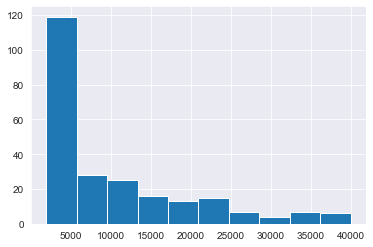

In [10]:
df.temp.hist()

Данные выглядят хорошо, нет выбросов (target feature)

<AxesSubplot:>

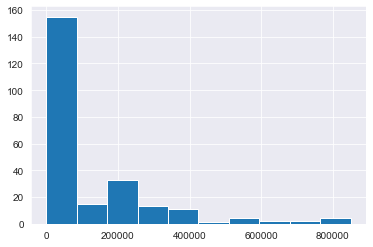

In [11]:
df.lumin.hist()

Данные выглядят хорошо, нет выбросов

<AxesSubplot:>

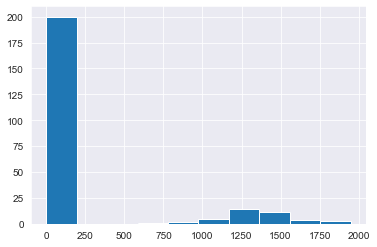

In [12]:
df.radius.hist()

Есть разрыв между данными, но это не похоже на выброс

<AxesSubplot:>

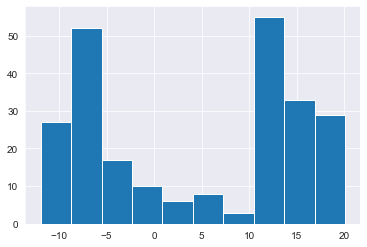

In [13]:
df.magnitude.hist()

Данные разбросанные, но это не похоже на выброс

# Подготовка данных

In [14]:
pd.value_counts(df.color)

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: color, dtype: int64

In [15]:
df.color = df.color.replace({
    'Blue-white': 'Blue White',
    'Blue white': 'Blue White',
    'Blue white ': 'Blue White',
    'Blue-White': 'Blue White',
    'yellow-white': 'Yellow',
    'Yellowish White': 'Yellow',
    'White-Yellow': 'Yellow',
    'yellowish': 'Yellow',
    'Yellowish': 'Yellow',
    'Yellow White': 'Yellow',
    'white': 'White',
    'whitish': 'White',
    'Whitish': 'White',
    'Pale yellow orange': 'Orange',
    'Blue ': 'Blue',
    'Orange-Red': 'Orange'
})

In [16]:
pd.value_counts(df.color)

Red           112
Blue           56
Blue White     41
Yellow         15
White          12
Orange          4
Name: color, dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('temp', axis=1), df.temp, test_size=0.1, random_state=RANDOM_STATE)

In [18]:
X_train_num = X_train.drop(['color', 'type'], axis=1)
X_test_num = X_test.drop(['color', 'type'], axis=1)

In [19]:
columns_num = X_train_num.columns

In [20]:
scaler = StandardScaler()

In [21]:
scaler.fit(X_train_num)

StandardScaler()

In [22]:
X_train_num = scaler.transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

In [23]:
X_train_num = pd.DataFrame(X_train_num, columns=columns_num)
X_test_num = pd.DataFrame(X_test_num, columns=columns_num)

In [24]:
X_train_cat = X_train[['color', 'type']]
X_test_cat = X_test[['color', 'type']]

In [25]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [26]:
ohe.fit(X_train_cat)

OneHotEncoder(handle_unknown='ignore')

In [27]:
X_train_cat = ohe.transform(X_train_cat).toarray()
X_test_cat = ohe.transform(X_test_cat).toarray()

In [28]:
columns_cat = ohe.categories_[0].tolist()
columns_cat.extend(ohe.categories_[1].tolist())

In [29]:
columns_cat

['Blue', 'Blue White', 'Orange', 'Red', 'White', 'Yellow', 0, 1, 2, 3, 4, 5]

In [30]:
X_train_cat = pd.DataFrame(data=X_train_cat, columns=columns_cat)
X_test_cat = pd.DataFrame(data=X_test_cat, columns=columns_cat)

In [31]:
X_train = X_train_num.join(X_train_cat)
X_test = X_test_num.join(X_test_cat)

In [32]:
X_train_t = torch.FloatTensor(X_train.values)
X_test_t = torch.FloatTensor(X_test.values)
y_train_t = torch.FloatTensor(y_train.values)
y_test_t = torch.FloatTensor(y_test.values)

# Построение нейронной сети
- линейная сеть
- линейная сеть с 5 слоями
- линейная сеть с функцией активации

In [33]:
learning_rate = 0.001

In [34]:
class NetSimpleSingle(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons, n_out_neurons):
        super(NetSimpleSingle, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons)
        self.fc2 = nn.Linear(n_hidden_neurons, n_out_neurons)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [35]:
net_simple_single = NetSimpleSingle(15, 15, 1)
optimizer = torch.optim.Adam(net_simple_single.parameters(), lr=learning_rate)
n_epochs = 30000
loss = nn.MSELoss()

In [36]:
net_simple_single_mse_train = []
net_simple_single_mse_test = []

In [37]:
for epoch in range(n_epochs):
    optimizer.zero_grad()
    z_train_t = net_simple_single.forward(X_train_t).flatten()
    mse_value_train = loss(z_train_t, y_train_t)
    mse_value_train.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == n_epochs - 1:
        net_simple_single.eval()
        z_test_t = net_simple_single.forward(X_test_t).flatten()
        mse_value_test = loss(z_test_t, y_test_t)

        net_simple_single_mse_train.append(mse_value_train.item())
        net_simple_single_mse_test.append(mse_value_test.item())

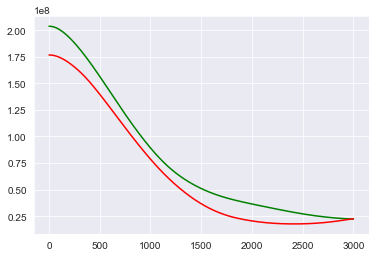

In [38]:
net_simple_single_mse_x = np.arange(len(net_simple_single_mse_test))
plt.plot(net_simple_single_mse_x, net_simple_single_mse_train, color='green')
plt.plot(net_simple_single_mse_x, net_simple_single_mse_test, color='red')
plt.show()

- ошибка высока
- остановить обучение надо было бы около 23000 epochs

In [39]:
net_simple_setup = []
n_hidden_layers = 5
for i in range(n_hidden_layers):
    net_simple_setup.append(nn.Linear(15, 15))
net_simple_setup.append(nn.Linear(15, 1)) # layer out

In [40]:
net_simple_five = nn.Sequential(*net_simple_setup)
n_epochs = 1000
optimizer = torch.optim.Adam(net_simple_five.parameters(), lr=learning_rate)
loss = nn.MSELoss()

In [41]:
net_simple_five_mse_train = []
net_simple_five_mse_test = []

In [42]:
for epoch in range(n_epochs):
    optimizer.zero_grad()
    z_train_t = net_simple_five.forward(X_train_t).flatten()
    mse_value_train = loss(z_train_t, y_train_t)
    mse_value_train.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == n_epochs - 1:
        net_simple_five.eval()
        z_test_t = net_simple_five.forward(X_test_t).flatten()
        mse_value_test = loss(z_test_t, y_test_t)
        mse_value_test.backward()

        net_simple_five_mse_train.append(mse_value_train.item())
        net_simple_five_mse_test.append(mse_value_test.item())

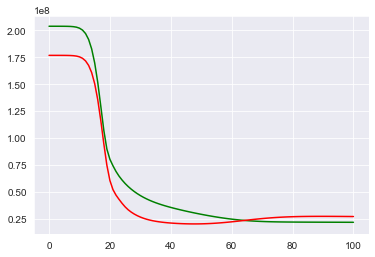

In [43]:
net_simple_five_mse_x = np.arange(len(net_simple_five_mse_test))
plt.plot(net_simple_five_mse_x, net_simple_five_mse_train, color='green')
plt.plot(net_simple_five_mse_x, net_simple_five_mse_test, color='red')
plt.show()

- ошибка не улучшилась, но благодаря слоям модель обучается быстрее

In [44]:
net_swish_setup = []
n_hidden_layers = 20
for i in range(n_hidden_layers):
    net_swish_setup.append(nn.Linear(15, 15))
    net_swish_setup.append(nn.Hardswish())
net_swish_setup.append(nn.Linear(15, 1)) # layer out

In [45]:
net_swish = nn.Sequential(*net_swish_setup)
n_epochs = 1000
optimizer = torch.optim.Adam(net_swish.parameters(), lr=learning_rate)
loss = nn.MSELoss()

In [46]:
net_swish_mse_train = []
net_swish_mse_test = []

In [47]:
for epoch in range(n_epochs):
    optimizer.zero_grad()
    z_train_t = net_swish.forward(X_train_t).flatten()
    mse_value_train = loss(z_train_t, y_train_t)
    mse_value_train.backward()
    optimizer.step()

    if epoch % 5 == 0 or epoch == n_epochs - 1:
        net_swish.eval()
        z_test_t = net_swish.forward(X_test_t).flatten()
        mse_value_test = loss(z_test_t, y_test_t)

        net_swish_mse_train.append(mse_value_train.item())
        net_swish_mse_test.append(mse_value_test.item())

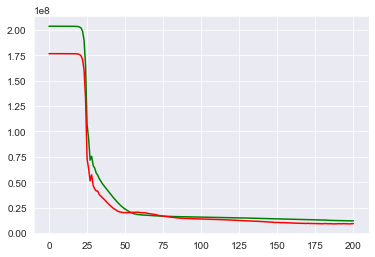

In [48]:
net_swish_mse_x = np.arange(len(net_swish_mse_train))
plt.plot(net_swish_mse_x, net_swish_mse_train, color='green')
plt.plot(net_swish_mse_x, net_swish_mse_test, color='red')
plt.show()

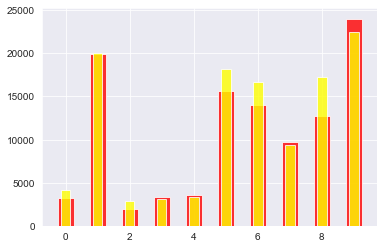

In [49]:
x = np.arange(10)
plt.bar(x, y_test_t.detach().numpy()[:10], width=0.5, alpha=0.8, color='red')
plt.bar(x, z_test_t.detach().numpy()[:10], width=0.3, alpha=0.8, color='yellow')
plt.show()

# Улучшение сети

- Dropout
- Batch Normalization

In [50]:
net_b_norm_setup = []
n_hidden_layers = 20
for i in range(n_hidden_layers):
    net_b_norm_setup.append(nn.Linear(15, 15))
    net_b_norm_setup.append(nn.BatchNorm1d(15))
    net_b_norm_setup.append(nn.Hardswish())
net_b_norm_setup.append(nn.Linear(15, 1)) # layer out

In [51]:
net_b_norm = nn.Sequential(*net_b_norm_setup)
n_epochs = 1200
optimizer = torch.optim.Adam(net_b_norm.parameters(), lr=learning_rate)
loss = nn.MSELoss()

In [52]:
net_b_norm_mse_train = []
net_b_norm_mse_test = []

In [53]:
for epoch in range(n_epochs):
    optimizer.zero_grad()
    z_train_t = net_b_norm.forward(X_train_t).flatten()
    mse_value_train = loss(z_train_t, y_train_t)
    mse_value_train.backward()
    optimizer.step()

    rmse = torch.sqrt(torch.sum(torch.pow(y_test_t - z_test_t, 2))).item()
    if rmse <= 4500:
        print(rmse)
        break

    if epoch % 5 == 0 or epoch == n_epochs - 1:
        net_b_norm.eval()
        z_test_t = net_b_norm.forward(X_test_t).flatten()
        mse_value_test = loss(z_test_t, y_test_t)

        net_b_norm_mse_train.append(mse_value_train.item())
        net_b_norm_mse_test.append(mse_value_test.item())

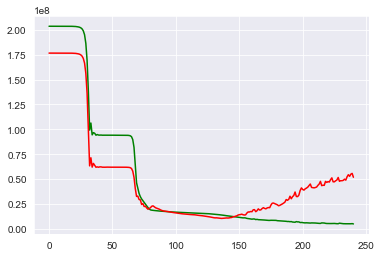

In [54]:
net_b_norm_mse_x = np.arange(len(net_b_norm_mse_train))
plt.plot(net_b_norm_mse_x, net_b_norm_mse_train, color='green')
plt.plot(net_b_norm_mse_x, net_b_norm_mse_test, color='red')
plt.show()

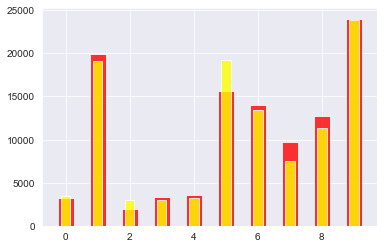

In [55]:
x = np.arange(10)
plt.bar(x, y_test_t.detach().numpy()[:10], width=0.5, alpha=0.8, color='red')
plt.bar(x, z_test_t.detach().numpy()[:10], width=0.3, alpha=0.8, color='yellow')
plt.show()

In [56]:
net_drop_setup = []
n_hidden_layers = 20
for i in range(n_hidden_layers):
    net_drop_setup.append(nn.Linear(15, 15))
    net_drop_setup.append(nn.Dropout(p=0.5))
    net_drop_setup.append(nn.Hardswish())
net_drop_setup.append(nn.Linear(15, 1)) # layer out

In [57]:
net_drop = nn.Sequential(*net_drop_setup)
n_epochs = 1400
optimizer = torch.optim.Adam(net_drop.parameters(), lr=learning_rate)
loss = nn.MSELoss()

In [58]:
net_drop_mse_train = []
net_drop_mse_test = []

In [59]:
for epoch in range(n_epochs):
    optimizer.zero_grad()
    z_train_t = net_drop.forward(X_train_t).flatten()
    mse_value_train = loss(z_train_t, y_train_t)
    mse_value_train.backward()
    optimizer.step()

    rmse = torch.sqrt(torch.sum(torch.pow(y_test_t - z_test_t, 2))).item()
    if rmse <= 4500:
        print(rmse)
        break

    if epoch % 5 == 0 or epoch == n_epochs - 1:
        net_drop.eval()
        z_test_t = net_drop.forward(X_test_t).flatten()
        mse_value_test = loss(z_test_t, y_test_t)

        net_drop_mse_train.append(mse_value_train.item())
        net_drop_mse_test.append(mse_value_test.item())

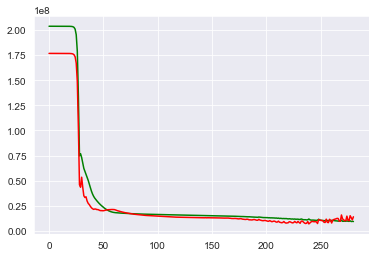

In [60]:
net_drop_mse_x = np.arange(len(net_drop_mse_train))
plt.plot(net_drop_mse_x, net_drop_mse_train, color='green')
plt.plot(net_drop_mse_x, net_drop_mse_test, color='red')
plt.show()

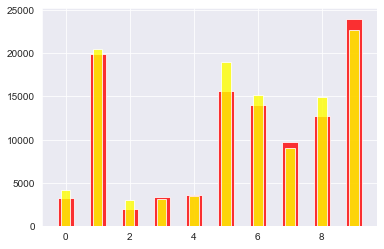

In [61]:
x = np.arange(10)
plt.bar(x, y_test_t.detach().numpy()[:10], width=0.5, alpha=0.8, color='red')
plt.bar(x, z_test_t.detach().numpy()[:10], width=0.3, alpha=0.8, color='yellow')
plt.show()

In [62]:
rmse = torch.sqrt(torch.sum(torch.pow(y_test_t - z_test_t, 2))).item()

In [63]:
print(rmse)

18378.369140625


# Выводы

- У меня не получилось добиться результата, rmse 4500, мне нужен совет.